In [1]:
%run ../setup_notebook.ipynb

/home/tplas/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1109: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/tplas/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/tplas/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/tplas/repos/dnp-code/PGM3_correct/source/numba_utilities.py:946: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


/home/tplas/repos/dnp-code/rbm_pipeline_functions.py


/home/tplas/anaconda3/envs/zf-rbm_py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /home/tplas/data/zf/20180912_Run01_spontaneous_rbm2.h5
len test inds 1665


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.patches
import itertools
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar
import svgutils.compose as sc
import IPython.display as ip

In [3]:
username = os.getlogin()
sys.path.append(f'/home/{username}/repos/dnp-code/')
sys.path.append(f'/home/{username}/repos/dnp-code/PGM3_correct/source/')
import rbm, utilities

import plotting_functions as pf
import analysis_functions as af
import swap_sign_RBM as ssrbm
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2

In [4]:
mom_names = {'means_v': r'$\langle v_i \rangle$', 'means_h': r'$\langle h_\mu \rangle$', 'pwcorr_vh': r'$\langle v_i h_\mu \rangle$',
             'pwcorr_vh_corr': r'$\langle v_i h_\mu \rangle$', 'reconstruct': 'LLH index of reconstruction',
              'pwcorr_vv': r'$\langle v_i v_j \rangle$', 'pwcorr_hh': r'$\langle h_\mu h_\nu \rangle$', 
            'pwcorr_vv_corr': r'$\langle v_i v_j \rangle - \langle v_i \rangle \langle v_j \rangle$', 
             'pwcorr_hh_corr': r'$\langle h_\mu h_\nu \rangle - \langle h_\mu \rangle \langle h_\nu \rangle$'}
kl = list(mom_names.keys())
for kk in kl:
    mom_names[kk + '_shuffled'] = f'Shuffled {mom_names[kk]}'
mom_colors = {'means_v': 'blue', 'means_h': 'red', 'pwcorr_vh': 'orange',
              'pwcorr_vv': 'green', 'pwcorr_hh': 'purple', 'recon_llh': 'grey'}
for xx in ['pwcorr_vv', 'pwcorr_hh', 'pwcorr_vh']:
    mom_colors[xx + '_corr'] = mom_colors[xx]

# Tables

- Load pre-computed tables.

- Plot tables per metric

In [4]:
df_folder = '/home/thijs/repos/dnp-code/results_df_lookup/'
df_names = ['df_lookup__burstsTrue_testtest_2020-06-17__20180912-Run01.h5']

# df_lookup_dict = {ii: pd.read_hdf(x) for ii, x in enumerate(df_names)}
# df_lookup_2 = pd.read_hdf('/home/thijs/repos/dnp-code/results_df_lookup/df_lookup__burstsTrue_testtest_2020-02-22__20180912-Run01.h5')
# assert (df_lookup_1.columns == df_lookup_2.columns).all()

df_lookup = pd.concat([pd.read_hdf(df_folder + x) for x in df_names])

## Load binned stats
binned_stats_dict = {}
for fn in df_names:

    binned_stats_name = (df_folder + 'binned_stats_dict__' + 
                         fn.lstrip('df_lookup').rstrip('h5') + 'pkl')

    binned_stats_dict = {**binned_stats_dict, **pickle.load(open(binned_stats_name, 'rb'))}
print(binned_stats_dict['settings'].keys())

test_segs = binned_stats_dict['settings']['test_segs']
data_set = binned_stats_dict['settings']['data_set']
name_tt_stats = f'/home/thijs/repos/dnp-code/results_df_lookup/traintest_stats/{data_set}/train_test_stats__test{test_segs}_split.pkl'
tt_stats_dict = pickle.load(open(name_tt_stats, 'rb'))
## Info
# The value of a dict entry binned_stats_dict[ts_rbm][mom] 
# is (plot_bins, mean_g_bins, std_g_bins)

dict_keys(['correct_vv_pwcorr', 'correct_hh_pwcorr', 'correct_vh_pwcorr', 'use_bursts', 'descr_traintest', 'multiple_rbm_path', 'mom_pearson', 'include_nan_rbms', 'nv_threshold_moments', 'data_set', 'data_path', 'generated_data_folder', 'train_inds_path', 'test_segs', 'gen_names', 'gen_nchains', 'gen_lengthchains', 'gen_nthermalize', 'gen_nsteps'])


In [5]:
binned_stats_dict['2020-05-16-0844']['pwcorr_hh_corr']

{'correlation': None,
 'lr_slope_bins': None,
 'lr_intercept_bins': None,
 'plot_bins': None,
 'means_bins': None,
 'std_bins': None,
 'sse': 603.1043,
 'n_elements': 19900,
 'mse': 0.03030674920010207,
 'rmse': 0.1740883373465956,
 'mean_r': 0.04961476,
 'mean_g': 0.011126197,
 'lr_slope': 0.487376,
 'lr_intercept': -0.013054847,
 'lr_xaxis': 'stat_r',
 'histogram2d': (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([-1.02879488, -0.98500961, -0.94122434, -0.89743906, -0.85365379,
         -0.80986851, -0.76608324, -0.72229797, -0.67851269, -0.63472742,
         -0.59094214, -0.54715687, -0.5033716 , -0.45958632, -0.41580105,
         -0.37201577, -0.3282305 , -0.28444523, -0.24065995, -0.19687468,
         -0.1530894 , -0.10930413, -0.06551886, -0.02173358,  0.02205169,
   

In [14]:
for pp in df_lookup.sort_values(by=['nhu', 'l1'])['fullpath']:
    print(pp.split('/')[-1])

RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-5e-03_duration159501s_timestamp2020-04-23-1152.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-1e-02_duration160236s_timestamp2020-04-23-1204.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-2e-02_duration129432s_timestamp2020-04-23-0330.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-5e-02_duration133743s_timestamp2020-04-22-0138.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-1e-01_duration132745s_timestamp2020-04-22-0124.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M5_l1-2e-01_duration121601s_timestamp2020-04-21-2221.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M10_l1-5e-03_duration140479s_timestamp2020-04-25-0253.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M10_l1-1e-02_duration140529s_timestamp2020-04-25-0306.data
RBM3_20180912-Run01-spontaneous-rbm2_wb_test-s

In [10]:
normalise_df = af.create_normalised_df(df=df_lookup, stats_bin=binned_stats_dict,
                           tt_stats=tt_stats_dict)
normalise_df['nhu'] = normalise_df['nhu'].astype('int')
# normalise_df

In [11]:
stat_mat = {}
list_comp_moms = ['means_v', 'means_h', 'pwcorr_vh_corr', 'pwcorr_vv_corr', 'pwcorr_hh_corr']

llh_table = pd.pivot_table(normalise_df, values='reconstruct', 
                           index='nhu', columns='l1')
print(list_comp_moms)
for iplot, stat in enumerate(list_comp_moms + ['reconstruct']):
    stat_mat[stat] = pd.pivot_table(normalise_df, values=stat, index='nhu', columns='l1')
min_proj = stat_mat[list_comp_moms[0]]
for stat in list_comp_moms[1:]:
    min_proj = min_proj.combine(stat_mat[stat], np.minimum)
    
norm_llh_table = llh_table #(llh_table[llh_table != 0] - np.nanmin(llh_table[llh_table != 0]))
# norm_llh_table = norm_llh_table / np.nanmax(norm_llh_table)  # normalise by highest LLH value because of scale mismatch with (other)stats 
# min_proj = min_proj.combine(norm_llh_table, np.minimum)

['means_v', 'means_h', 'pwcorr_vh_corr', 'pwcorr_vv_corr', 'pwcorr_hh_corr']


In [12]:
np.nanmax(norm_llh_table)

0.288911908864975

In [13]:
l1_shown = 0.02
nhu_shown = 200
ts_rbm = normalise_df[np.logical_and(normalise_df.l1 == l1_shown, 
                                     normalise_df.nhu == nhu_shown)].timestamp.values[0]
print(ts_rbm)

2020-05-16-0844


In [14]:
normalise_df[normalise_df['timestamp'] == '2020-05-16-0844']

,timestamp,nhu,l1,means_v,means_h,pwcorr_vh_corr,pwcorr_vv_corr,pwcorr_hh_corr,reconstruct
10,2020-05-16-0844,200,0.02,0.894647,0.85436,0.909936,1.089233,0.82781,0.239091


## Load GLM results

In [15]:
# ## Load GLM 
glm_path_folder_sweep = '/media/thijs/hooghoudt/logistic_regression_2021/1050neurons/'
glm_sweep_filenames = [x for x in os.listdir(glm_path_folder_sweep) if x[-3:] == '.h5']
n_glms = len(glm_sweep_filenames)
duration_glm_est = {}

def independent_model(data, eps=1e-6):
    data = np.asarray(data, dtype=np.float32)
    indep = data.mean(0)
    likelihood = np.log((indep + eps) * data + (1 - indep - eps) * (1 - data))
    return likelihood.sum(0)

def load_glm_median_llh(glm_hfile_path, verbose=0):
    glm_hfile = h5py.File(glm_hfile_path, 'r')
    if verbose > 0:
        print(glm_hfile.keys())
        
    tmp_glm_pred_dyn = glm_hfile['full_dyn_pred'].value
    
    glm_selected_neurons = glm_hfile['subset_neurons'][()]
    glm_labeled_selected_neurons = np.zeros_like(glm_selected_neurons)
    for i_n, n in enumerate(glm_selected_neurons):
        glm_labeled_selected_neurons[i_n] = int(np.where(selected_neurons['wb'] == n)[0])

    print(glm_hfile['lambda_sparsity'][()], np.round(1 / glm_hfile['C_sparsity'][()]), 
          np.round(glm_hfile['seconds_duration'][()] / 3600), glm_hfile['seconds_duration'][()])
    assert glm_hfile['lambda_sparsity'][()] == int(1 / glm_hfile['C_sparsity'][()])
    lambda_use = int(np.round(1 / glm_hfile['C_sparsity'][()]))
    array_corr_llh = np.zeros(len(glm_selected_neurons))
    for n_cell in range(tmp_glm_pred_dyn.shape[0]):
        llh_glm = af.llh1d(pred_trace=tmp_glm_pred_dyn[n_cell, :],
                           real_trace=test_data['wb'][glm_labeled_selected_neurons[n_cell], :])[0]
        llh_indep = independent_model(data=test_data['wb'][glm_labeled_selected_neurons[n_cell], :])
        array_corr_llh[n_cell] = (llh_glm - llh_indep) / (-1 * llh_indep)
    dur = glm_hfile['seconds_duration'][()]
    glm_hfile.close()
    return array_corr_llh, lambda_use, dur


                               
glm_sweep_llh_dict = {}
for i_glm, glm_name in enumerate(glm_sweep_filenames):
    tmp, lambda_use, tmp2 = load_glm_median_llh(glm_hfile_path=os.path.join(glm_path_folder_sweep, glm_name))
    glm_sweep_llh_dict[lambda_use] = tmp
    duration_glm_est[lambda_use] = tmp2

glm_path_folder_optimum = '/media/thijs/hooghoudt/logistic_regression_2021/5252neurons/'
glm_optimum_filename = os.listdir(glm_path_folder_optimum)[0]
glm_5k_cells, lambda_glm_opt, _ = load_glm_median_llh(glm_hfile_path=os.path.join(glm_path_folder_optimum, glm_optimum_filename),
                                                   verbose=1)

10000 10000.0 22.0 79564
100 100.0 22.0 78923
20 20.0 20.0 73311
200 200.0 23.0 81240
1000 1000.0 23.0 81414
99999 100000.0 18.0 64189
<KeysViewHDF5 ['C_sparsity', 'connect_mat_full', 'expl_var_full_test', 'expl_var_full_train', 'full_dyn_pred', 'lambda_sparsity', 'regressor_neurons', 'seconds_duration', 'subset_neurons', 'timestamp']>
1000 1000.0 16.0 57857


In [16]:
folder_rbms = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_combined/'
list_rbms = os.listdir(folder_rbms)
for i_rbm, rbm_name in enumerate(list_rbms):
    rbm_props = rbm_name.split('_')
    n_hu = rbm_props[4][1:]
    l_reg = rbm_props[5][3:]
    dur = rbm_props[6][8:-1]
#     print(n_hu, l_reg, np.round(int(dur) / 3600))

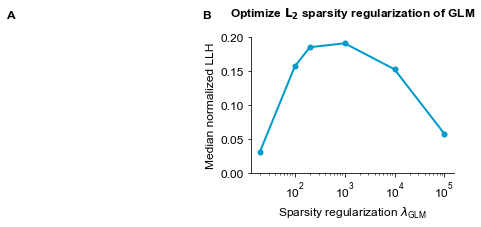

In [17]:
## Supp GLm
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
# ax_sweep = plt.subplot(111)
save_fig = False

ax_sweep = ax[1]
glm_spars = np.array(list(glm_sweep_llh_dict.keys()))
glm_meds = np.array([np.median(glm_sweep_llh_dict[x]) for x in glm_spars])
glm_meds = glm_meds[np.argsort(glm_spars)]
glm_spars = np.sort(glm_spars)
ax_sweep.plot(glm_spars, glm_meds, linestyle='-', 
              marker='.', linewidth=2, markersize=10, 
              c=dr_colors['glm'])
ax_sweep.set_xscale('log')
ax_sweep.set_xlabel('Sparsity regularization ' + r'$\lambda_{\mathregular{GLM}}$')
ax_sweep.set_ylabel('Median normalized LLH')
ax_sweep.set_title('Optimize ' + r'$\mathbf{L_2}$' + ' sparsity regularization of GLM',
                   fontdict={'weight': 'bold'}, y=1.1)
ax_sweep.spines['top'].set_visible(False)
ax_sweep.spines['right'].set_visible(False)
ax_sweep.set_ylim([0, 0.2]);

for sp in ['top', 'right', 'bottom', 'left']:
    ax[0].spines[sp].set_visible(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax_sweep.annotate(s='A', xy=(-1.2, 1.135), xycoords='axes fraction',
                  weight='bold')
ax_sweep.annotate(s='B', xy=(-.24, 1.135), xycoords='axes fraction',
                  weight='bold')

assert glm_spars[np.argmax(glm_meds)] == lambda_glm_opt, 'WARNING: optimum does not match'
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_glm_sweep.svg')

In [139]:
sc.Figure('130mm', '60mm',
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/sfig_glm_sweep.svg').scale(1).move(-66, 15)),
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/schematic_glm.svg').scale(4).move(34, 10))
         ).save('/home/thijs/repos/zf-rbm/figures/sfig_glm_sweep_complete.svg')
ip.SVG('/home/thijs/repos/zf-rbm/figures/sfig_glm_sweep_complete.svg')

In [18]:
print('RBM median: ', np.median(binned_stats_dict[ts_rbm]['reconstruct_corr']))
print('GLM median: ', np.median(glm_5k_cells))

RBM median:  0.23909147
GLM median:  0.19634340571455322


In [19]:
scipy.stats.mannwhitneyu(binned_stats_dict[ts_rbm]['reconstruct_corr'], glm_5k_cells, alternative='greater')

MannwhitneyuResult(statistic=153651320.0, pvalue=9.002571742915078e-43)

## Load data for bottom part of fig (weight stats)

In [5]:
### PCA & ICA
all_nr_methods = []
weights = {}
# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 200}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
    all_nr_methods.append(name)
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(200, 52518) pca


In [6]:
# rbm_path = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_reruns/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
rbm_path = '/home/tplas/data/zf/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
hu_assert = [1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67, 68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120, 124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175, 177, 181, 186, 188, 191, 198]  # HUs that sholud be swapped
tmp_RBM = pickle.load(open(rbm_path, 'rb'))
RBM = ssrbm.swap_sign_RBM(RBM=tmp_RBM, verbose=2, assert_hu_inds=hu_assert)
weights['rbm'] = RBM.weights.copy()

hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))
ol, tmp = af.opt_leaf(hu_act_test)
hu_act_test_remap = hu_act_test[ol, :]

45/200 HU weights are flipped
Flipped HUs are: (array([  1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67,
        68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120,
       124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175,
       177, 181, 186, 188, 191, 198]),)


In [7]:
## Uniformity of connectivity:
plot_methods = ['rbm', 'pca']
degree_distr, sh_degree_distr = {}, {}
print(f'Methods: {plot_methods}')
for dr in plot_methods:
    degree_distr[dr], sh_degree_distr[dr] = af.count_connections_3(weight_matrix=weights[dr])

Methods: ['rbm', 'pca']


# PLOT full fig new


In [23]:
arg_nhu, arg_l1 = np.where(min_proj == min_proj.max().max())
arg_nhu, arg_l1 = arg_nhu[0], arg_l1[0]
max_nhu = min_proj.iloc[arg_nhu, :].name
max_l1 = min_proj.iloc[:, arg_l1].name


arg_nhu_shown = arg_nhu
arg_l1_shown = arg_l1
nhu_shown = max_nhu
l1_shown = max_l1
print(f'M: {nhu_shown}, lambda: {l1_shown}')

M: 200, lambda: 0.02


In [24]:
min_proj.max().max()

0.8278099157638521

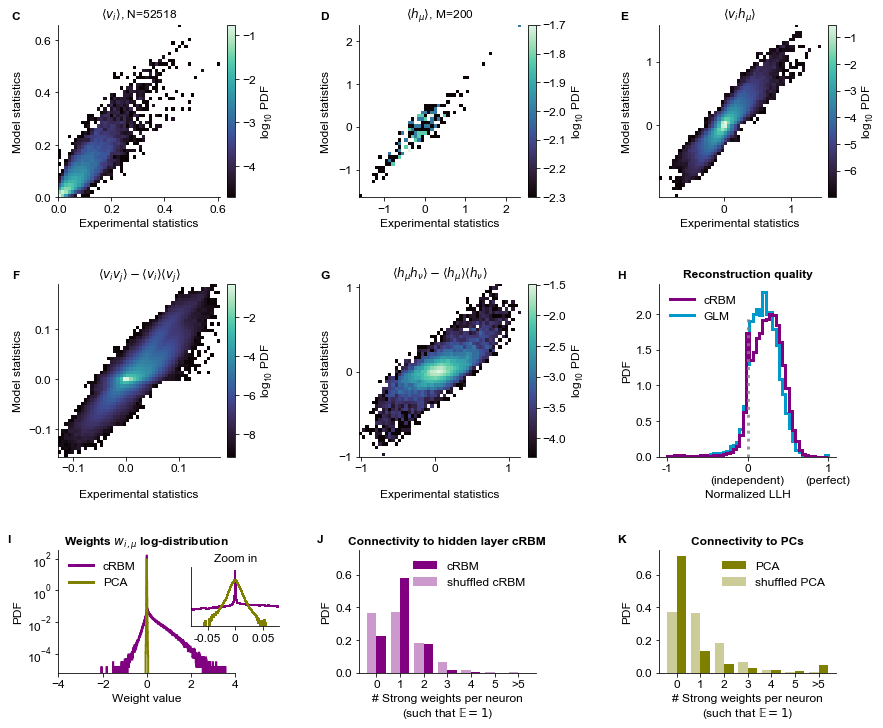

In [28]:
# plt.rcParams['text.latex.preamble'] = [r'\boldmath']
fig = plt.figure(figsize=[12, 10])
gs_stats = fig.add_gridspec(ncols=3, nrows=2, bottom=0.35, top=0.95,
                            right=0.95, left=0.05, hspace=0.5, wspace=0.7)
gs_weights = fig.add_gridspec(ncols=3, nrows=1, bottom=0.05, top=0.22,
                            right=0.95, left=0.05, hspace=0.5, wspace=0.7)
save_fig = True


## SINGLE RBM
ax_dict, im = {}, {}
for i_stat, stat in enumerate(list_comp_moms):
    ax_dict[i_stat] = fig.add_subplot(gs_stats[i_stat])
    (density, xbins, ybins) = binned_stats_dict[ts_rbm][stat]['histogram2d']
    density = density / np.sum(np.sum(density)) # normalise to 1
    pf.plot_one_stat(density=density, xbins=xbins, ybins=ybins, 
                     ax=ax_dict[i_stat], title=mom_names[stat])

ax_dict[0].set_title(r'$\langle v_i \rangle$' + ', N=52518')
ax_dict[1].set_title(r'$\langle h_\mu \rangle$' + ', M=200')

ax_dict[0].set_xticks([0, 0.2, 0.4, 0.6])
ax_dict[0].set_yticks([0, 0.2, 0.4, 0.6])
    
ax_dict[5] = fig.add_subplot(gs_stats[5])
density = binned_stats_dict[ts_rbm]['reconstruct_corr']
ax_dict[5].plot([0, 0], [0, 2], ':', c='grey', alpha=0.8)
ax_dict[5].hist(glm_5k_cells, bins=np.linspace(-1, 1, 50), density=True,
         histtype='step', color=dr_colors['glm'], linewidth=3, label='GLM')

ax_dict[5].hist(density, bins=np.linspace(-1, 1, 50), density=True, 
         histtype='step', color=dr_colors['rbm'], linewidth=3, label='cRBM')

handle_dict_llh = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'glm']}
ax_dict[5].legend(handles=[handle_dict_llh['rbm'], handle_dict_llh['glm']],
                labels=['cRBM', 'GLM'],
                frameon=False, loc='upper left');


# ax_dict[5].legend(frameon=False, loc='upper left')


# ax_dict[5].set_title(mom_names['reconstruct'] + f'\nMedian = {np.round(normalise_df[normalise_df.timestamp == ts_rbm]["reconstruct"].values[0], 2)}')
ax_dict[5].set_title('Reconstruction quality', fontdict={'weight': 'bold'})
ax_dict[5].set_xlabel('Normalized LLH'); ax_dict[5].set_ylabel('PDF');
ax_dict[5].spines['top'].set_visible(False)
ax_dict[5].spines['right'].set_visible(False)
ax_dict[5].set_xticklabels(['', '-1', '0\n(independent)', '1\n(perfect)'])

# ax_dict[1].text(s=f'RBM: {ts_rbm}, M: {nhu_shown}, l1: {l1_shown}', x=-3, y=3,
#                 fontdict={'weight': 'bold'});  # ID of RBM

## Weights distribution
ax_mainw = fig.add_subplot(gs_weights[0])
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_names[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights ' + r'$w_{i, \mu}$' + ' log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_mainw.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_names['rbm'], dr_names['pca']],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_names[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Uniformity plots
ax_unif = {}
for i_dr, dr in enumerate(['rbm', 'pca']):
    ax_unif[dr] = fig.add_subplot(gs_weights[1 + i_dr])
    pf.plot_degree_distr(degree_dict=degree_distr, degree_dict_sh=sh_degree_distr,
                         dr=dr, ax=ax_unif[dr], cutoff=6, normalise=True)
    ax_unif[dr].set_ylim([0, 0.75])
ax_unif['pca'].set_title('Connectivity to PCs', 
                         fontdict={'weight': 'bold'})


## Alignment:
fig.align_ylabels(axs=[ax_dict[0], ax_dict[3], ax_mainw])
fig.align_ylabels(axs=[ax_dict[1], ax_dict[4], ax_unif['rbm']])
fig.align_ylabels(axs=[ax_dict[2], ax_dict[5], ax_unif['pca']])

fig.align_xlabels(axs=[ax_dict[0], ax_dict[1], ax_dict[2]])
fig.align_xlabels(axs=[ax_dict[3], ax_dict[4], ax_dict[5]])
fig.align_xlabels(axs=[ax_mainw, ax_unif['rbm'], ax_unif['pca']])

for i_lab, lab in enumerate(['C', 'F']):
    ax_dict[i_lab * 3].annotate(s=lab, xycoords='axes fraction', xy=(-0.29, 1.03), 
                      fontweight='bold')
tmp_inds = [1, 2, 4, 5]
for i_lab, lab in enumerate(['D', 'E', 'G', 'H']):
    ax_dict[tmp_inds[i_lab]].annotate(s=lab, xycoords='axes fraction', xy=(-0.24, 1.03), 
                  fontweight='bold')
ax_mainw.annotate(s='I', xycoords='axes fraction', xy=(-0.29, 1.06), 
                  fontweight='bold')
ax_unif['rbm'].annotate(s='J', xycoords='axes fraction', xy=(-0.24, 1.06), 
                  fontweight='bold')
ax_unif['pca'].annotate(s='K', xycoords='axes fraction', xy=(-0.24, 1.06), 
                  fontweight='bold')
               
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_stats_convergence.svg',
                bbox_inches='tight')
                    

In [29]:
sc.Figure('174mm', '204mm',
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/figure_convergence/rbm_AND_generation_schematic.svg').scale(3.65).move(12, 4)),
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/fig_stats_convergence.svg').scale(0.74).move(2, 230)),
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/figure_convergence/icons_only.svg').scale(2.1).move(50, 250))
#           sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/figure_convergence/icons_only.svg').scale(2.1).move(167, 230))
                  ).save('/home/thijs/repos/zf-rbm/figures/fig_stats_convergence_complete.svg')
ip.SVG('/home/thijs/repos/zf-rbm/figures/fig_stats_convergence_complete.svg')

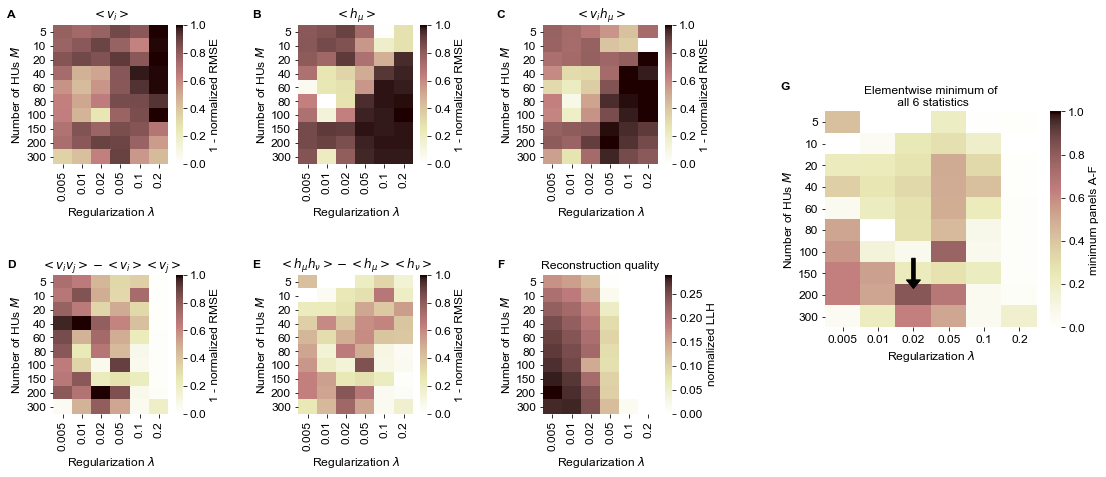

In [102]:
      
## ALL RBMS
save_fig = True
list_comp_moms = ['means_v', 'means_h', 'pwcorr_vh_corr', 
                  'pwcorr_vv_corr', 'pwcorr_hh_corr']

fig = plt.figure(constrained_layout=False, figsize=[16, 6])
gs_moms = fig.add_gridspec(ncols=3, nrows=2, bottom=0.05, top=0.95,
                         hspace=0.8, wspace=0.7, left=0.05, right=0.6)  # [1, 2.2, 1.2]
gs_summ = fig.add_gridspec(ncols=1, nrows=1, bottom=0.25, top=0.75,
                          hspace=0.5, wspace=0.5, left=0.72, right=0.95)
ax_hm = {}
for iplot, stat in enumerate(list_comp_moms):
    ax_hm[iplot] = fig.add_subplot(gs_moms[iplot])
    sns.heatmap(pd.pivot_table(normalise_df, values=stat, 
                               index='nhu', columns='l1'), 
                vmin=0, ax=ax_hm[iplot],
                vmax=1,#np.percentile(normalise_df[stat], 85),
                cmap='pink_r', cbar_kws={'label': '1 - normalized RMSE'},
                rasterized=True)
    b, t = ax_hm[iplot].get_ylim() # correct for default cut off
    b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
    t -= 0.5 # 
    ax_hm[iplot].set_ylim(b, t) # u
    ax_hm[iplot].set_title(mom_names[stat])
    ax_hm[iplot].set_ylabel('Number of HUs $M$')
    ax_hm[iplot].set_xlabel('Regularization ${\lambda}$')


ax_hm['llh'] = fig.add_subplot(gs_moms[5])
llh_table = pd.pivot_table(normalise_df, values='reconstruct', 
                           index='nhu', columns='l1')
sns.heatmap(llh_table, #vmin=np.nanmin(llh_table[llh_table != 0]), 
            vmax=np.nanmax(llh_table[llh_table != 0]),
            vmin= 0, cmap='pink_r', ax=ax_hm['llh'], 
            cbar_kws={'label': 'normalized LLH'},
            rasterized=True);
b, t = ax_hm['llh'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
ax_hm['llh'].set_ylim(b, t) # u
ax_hm['llh'].set_title('Reconstruction quality');

ax_hm['llh'].set_ylabel('Number of HUs $M$')
ax_hm['llh'].set_xlabel('Regularization ${\lambda}$')

                     
## SUMMARY 
ax_summ = fig.add_subplot(gs_summ[0])
sns.heatmap(min_proj, vmin=0, vmax=1, 
            annot=False, cmap='pink_r', ax=ax_summ,
            cbar_kws={'label': 'minimum panels A-F'},
            rasterized=True)
b, t = ax_summ.get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 #

ax_summ.arrow(2.5, 6.8, 0, 1, head_width=0.4, head_length=0.4,
              fc='k', ec='k', width=0.1)

ax_summ.set_ylabel('Number of HUs $M$')
ax_summ.set_xlabel('Regularization ${\lambda}$')

# ax_summ.add_patch(matplotlib.patches.Rectangle((arg_l1_shown, arg_nhu_shown), 1, 1, 
#                                            fill=False, edgecolor='blue', lw=3))  # highlight top choice

ax_summ.set_ylim(b, t) # update the ylim(bottom, top) values
ax_summ.set_yticklabels(ax_summ.yaxis.get_ticklabels(), rotation=0)
ax_summ.set_title('Elementwise minimum of\n all 6 statistics')
                     

for i_lab, lab in enumerate(['A', 'B' ,'C', 'D', 'E']):
    ax_hm[i_lab].annotate(s=lab, xycoords='axes fraction', xy=(-0.4, 1.05), 
                      fontweight='bold')

ax_hm['llh'].annotate(s='F', xycoords='axes fraction', xy=(-0.4, 1.05), 
                  fontweight='bold')
ax_summ.annotate(s='G', xycoords='axes fraction', xy=(-0.21, 1.1), 
                  fontweight='bold')
    
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_model_selection.pdf',
                bbox_inches='tight')
#     plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_model_selection.svg',
#                 bbox_inches='tight')
                      

In [48]:
sc.Figure('174mm', '129mm',
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/figure_intro/generate_data_wide.svg').scale(2.8).move(110, 4)),
          sc.Panel(sc.SVG('/home/thijs/repos/zf-rbm/figures/sfig_model_selection.svg').scale(0.59).move(4, 205))
                  ).save('/home/thijs/repos/zf-rbm/figures/sfig_model_selection_complete.svg')
ip.SVG('/home/thijs/repos/zf-rbm/figures/sfig_model_selection_complete.svg')

## Evaluate VAE results

Because of memory issues, if you want to compute pwcorr_vv, do it in following order:
- Imports without setup_notebook
- Load env
- Comment (ie do not run) the dict_stats['pearson_ci'] = pearsonr_ci() line in rpf.compute_moment_corrs().compute_dict_add_stats()
- Do section 'Compute corr' until 'end corr'

When that's done (and you've got pwcorr_vv), then do the rest
- Import setup notebook
- Import RBM, PCA, their weights and distr (above in 'load bottom part fig')
- Do rest below here
- Make fig

In [8]:
## Load VAE results:
vae_results_path = '/home/tplas/data/zf/VAE/VAE_results.data'
env = pickle.load(open(vae_results_path,'rb'))
Ms = env['Ms']
l1s = env['l1s']
grid_train_likelihood = env['grid_train_likelihood']
grid_test_likelihood = env['grid_test_likelihood']

# index= np.argmax(grid_test_likelihood.flatten())
# index_M = index // len(l1s)
# index_l1 = index % len(l1s)

In [9]:

# vae_results_path_or = '/home/tplas/data/zf/VAE/VAE_results.data'
# env_or = pickle.load(open(vae_results_path_or,'rb'))
# env['spikes_test'] = env_or['spikes_test']
# env_or = None

print(env.keys())
# env['W'].shape

weights['vae'] = env['W']
dr_colors['vae'] = '#037c6e'
dr_names['vae'] = 'VAE'
plot_methods = ['rbm', 'vae']

import plotting_functions as pf
degree_distr['vae'], sh_degree_distr['vae'] = af.count_connections_3(weight_matrix=weights['vae'])


dict_keys(['Ms', 'l1s', 'spikes_train', 'spikes_test', 'grid_train_likelihood', 'grid_test_likelihood', 'artificial_spikes', 'reconstruction_spikes', 'W'])


In [10]:
import pickle
test_segs = '267'
train_inds_path=f'/home/tplas/repos/dnp-code/train_test_inds/20180912-Run01/train_test_inds__test_segs_{test_segs}_nseg10.pkl'  # HARD SET TO 10TH PERCENTILE OF 20180912-RUN01 (TEST SEGS 267)
dict_tt_inds = pickle.load(open(train_inds_path, 'rb'))  # load dictionary with training indices
train_inds = dict_tt_inds['train_inds']  # load training inds, note that: # test_inds = dict_tt_inds['test_inds']
test_inds = dict_tt_inds['test_inds']
print(len(test_inds))

1665


In [11]:
def reconstruction_likelihood(data, recon_data, eps=1e-6):
    data = np.asarray(data, dtype=np.float32)
    likelihood = np.log((recon_data + eps) * data + (1 - recon_data - eps) * (1 - data))
    return likelihood.mean(0)

def independent_model(data, eps=1e-6):
        data = np.asarray(data, dtype=np.float32)
        indep = data.mean(0)
        likelihood = np.log((indep + eps) * data + (1 - indep - eps) * (1 - data))
        return likelihood.mean(0)

recon_error_vae = reconstruction_likelihood(data=env['spikes_test'], 
                                        recon_data=env['reconstruction_spikes'][test_inds, :])
recon_error_indep = independent_model(data=env['spikes_test'])

## Computing corr:

In [12]:
sys.path.append('/home/tplas/repos/dnp-code/')
import rbm_pipeline_functions as rpf

In [13]:
print(env.keys())
env['spikes_train'] = None 
env['reconstruction_spikes'] = None 
env['W'] = None 

dict_keys(['Ms', 'l1s', 'spikes_train', 'spikes_test', 'grid_train_likelihood', 'grid_test_likelihood', 'artificial_spikes', 'reconstruction_spikes', 'W'])


In [11]:
list_comp_moms = ['means_v']
# list_comp_moms = ['means_v']
inds_art_tp = np.arange(len(test_inds))
assert len(inds_art_tp) == 1665
# dict_binned_stats_vae = {}

for comp_moment in list_comp_moms:
    print(f'Calculating {comp_moment}')
    _, __, dict_binned_stats_vae[comp_moment] = rpf.compute_moment_corrs(rv=env['spikes_test'].T, rh=np.zeros((1, 1)), precomputed_rvv_mat_flat=None,
                                                   gv=env['artificial_spikes'][inds_art_tp, :].T, gh=None, mompearson2nd='moment',
                                                   correct_pwcorr_vh=False, rbm=None,
                                                   correct_pwcorr_vv=True, correct_pwcorr_hh=False,
                                                   moment=comp_moment, nv_tresh=100000, return_binned_stats=False,
                                                   compute_additional_stats=True, vv_inds=None, shuffle_neurons=False,
                                                   compute_expensive_stats=True, verbose=1)

dict_binned_stats_vae['inds_used_for_artificial_spikes'] = inds_art_tp

Calculating means_v
computing add stats
computing regular stats
computing expensive stats
regression
reducing dtype
histogram
correlation
shuffle perms
shuffle stas


In [17]:
ff = open('/home/tplas/repos/zf-rbm/Content/dict_binned_stats_vae_M200_l2e-2_20221111.pkl', 'wb')
pickle.dump(dict_binned_stats_vae, ff)
ff.close()

In [13]:
dict_binned_stats_vae = pickle.load(open('/home/tplas/repos/zf-rbm/Content/dict_binned_stats_vae_M200_l2e-2_20221111.pkl', 'rb'))

In [14]:
# dict_binned_stats_vae

nrmse_vae = {}

for stat in ['pwcorr_vv', 'means_v']:
    name_tt_stats = f'/home/tplas/repos/dnp-code/results_df_lookup/traintest_stats/{data_set}/train_test_stats__test{test_segs}_split.pkl'
    tt_stats_dict = pickle.load(open(name_tt_stats, 'rb'))
    if stat == 'means_v':
        tt_stat = 'means_v'
    elif stat == 'pwcorr_vv':
        tt_stat = 'pwcorr_vv_corr'
    tmp_stat_opt = np.sqrt(tt_stats_dict[tt_stat]['sse'] / tt_stats_dict[tt_stat]['n_elements'])
    nrmse_vae[stat] = af.correct_stat(s_old=dict_binned_stats_vae[stat]['rmse'], 
                                        s_naive=dict_binned_stats_vae[stat]['rmse_shuffled'],
                                        s_opt=tmp_stat_opt)
print(nrmse_vae)

{'pwcorr_vv': 1.2278614288243823, 'means_v': 0.6083583139516665}


In [34]:
dict_binned_stats_vae

{'pwcorr_vv': {'sse': 20662.068,
  'n_elements': 1379043903,
  'mse': 1.4982893811013789e-05,
  'rmse': 0.00387077431672447,
  'mean_r': 0.0015644667,
  'mean_g': 2.8461625e-06,
  'lr_slope': 0.0030665027,
  'lr_intercept': -1.9512793e-06,
  'lr_xaxis': 'stat_r',
  'histogram2d': (array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]),
   array([-0.12695312, -0.12086914, -0.11478516, -0.10870117, -0.10261719,
          -0.0965332 , -0.09044922, -0.08436523, -0.07828125, -0.07219727,
          -0.06611328, -0.0600293 , -0.05394531, -0.04786133, -0.04177734,
          -0.03569336, -0.02960937, -0.02352539, -0.01744141, -0.01135742,
          -0.00527344,  0.00081055,  0.00689453,  0.01297852,  0.0190625 ,
           0.02514648,  0.03123047,  0.03731445,  0.04339844,  0.04948242,
        

### End corr

In [15]:
import copy

def get_assembly_sizes(weight_mat, threshold=0.01, normalise_by_n_neurons=True):
    assert type(weight_mat) == np.ndarray
    assert weight_mat.ndim == 2
    if weight_mat.shape[0] < weight_mat.shape[1]:
        dim_hus = 1
    else:
        dim_hus = 0
    assembly_sizes = np.sum(np.abs(weight_mat) > threshold, dim_hus)
    if normalise_by_n_neurons:
        assembly_sizes = assembly_sizes / weight_mat.shape[1]
    
    assert len(assembly_sizes) < 500, 'more HUs than expected'
    return assembly_sizes
   

# https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib


In [21]:
print(weights['vae'].shape)
sign_weights = np.sign(weights['vae'].sum(1))
change_sign = sign_weights < 0 
print(change_sign.sum())
weights['vae_swappedsign'] = copy.deepcopy(weights['vae'])
weights['vae_swappedsign'][change_sign, :] *= -1
assert np.sign(weights['vae_swappedsign'].sum(1)).sum() == weights['vae_swappedsign'].shape[0]

(200, 52518)
104


### Total supp fig VAE:

/home/tplas/repos/zf-rbm/figure_notebooks/plotting_functions.py:584: RuntimeWarning: divide by zero encountered in log10
  image = ax.imshow(np.log10(density),


{'rbm': 199, 'vae': 78}


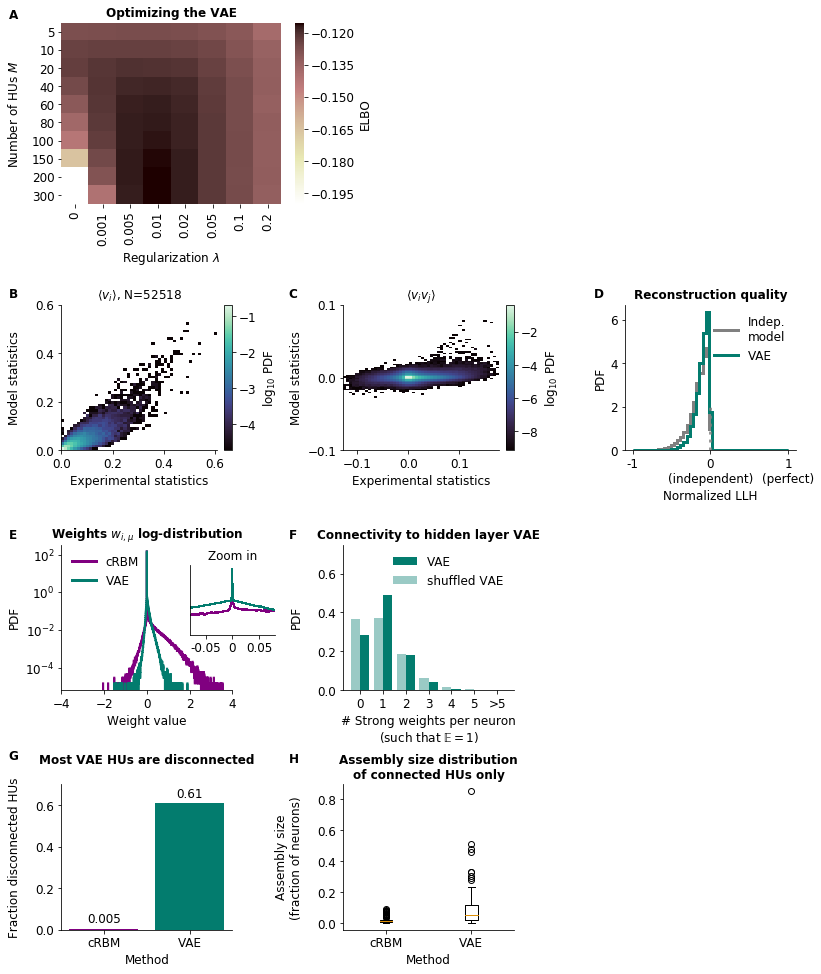

In [23]:
save_fig = True

fig = plt.figure(figsize=(12, 14), constrained_layout=False)

gs_hm = fig.add_gridspec(nrows=1, ncols=2, top=0.95, bottom=0.77, left=0.1, right=0.8)
gs_stats = fig.add_gridspec(nrows=3, ncols=3, top=0.67, bottom=0.05, left=0.1, right=0.95, wspace=0.65, hspace=0.65)

ax_hm_test = fig.add_subplot(gs_hm[0])

sns.heatmap(grid_test_likelihood, ax=ax_hm_test, vmin=-0.2,
            cmap='pink_r', cbar_kws={'label': 'ELBO'}, rasterized=True);
# ax_hm_test.scatter(index_l1 + 0.5,index_M + 0.5, c = 'green')
# ax_hm_test.scatter(4 + 0.5, 8 + 0.5, c= 'yellow')
# b, t = ax_hm_test.get_ylim() # correct for default cut off
# b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
# t -= 0.5 # 
# ax_hm_test.set_ylim(b, t) # u

ax_hm_test.set_xticks(0.5 + np.arange(8))
ax_hm_test.set_xticklabels(l1s)
ax_hm_test.set_xlabel('Regularization ${\lambda}$')
ax_hm_test.set_yticks(0.5 + np.arange(10))
ax_hm_test.set_yticklabels(Ms)
ax_hm_test.set_ylabel('Number of HUs $M$')
ax_hm_test.set_title('Optimizing the VAE', fontdict={'weight': 'bold'})

ax_hm_test.set_xticklabels(ax_hm_test.get_xticklabels(), rotation=90)
ax_hm_test.set_yticklabels(ax_hm_test.get_yticklabels(), rotation=0)



ax_stats_dict = {} 
irow, icol, iplot = 0, 0, 0
for iplot in range(9):
    ax_stats_dict[iplot] = fig.add_subplot(gs_stats[irow, icol])
    icol += 1
    if icol == 3:
        icol = 0 
        irow += 1

## hist correlation:
## SINGLE RBM
list_comp_moms = ['means_v', 'pwcorr_vv']
for i_stat, stat in enumerate(list_comp_moms):
    (density, xbins, ybins) = dict_binned_stats_vae[stat]['histogram2d']
    density = density / np.sum(np.sum(density)) # normalise to 1
    pf.plot_one_stat(density=density, xbins=xbins, ybins=ybins, 
                     ax=ax_stats_dict[i_stat], title=mom_names[stat])
    # pf.equal_xy_lims(ax=ax_stats_dict[i_stat])

ax_stats_dict[0].set_title(r'$\langle v_i \rangle$' + ', N=52518')
ax_stats_dict[1].set_title(r'$\langle v_i v_j \rangle$')

ax_stats_dict[0].set_xticks([0, 0.2, 0.4, 0.6])
ax_stats_dict[0].set_yticks([0, 0.2, 0.4, 0.6]);
    
## Reconstruction likelihood:
ax_recon = ax_stats_dict[2]
ax_recon.plot([0, 0], [0, 2], ':', c='grey', alpha=0.8)

dr_colors['indep'] = 'grey'
ax_recon.hist(recon_error_indep, bins=np.linspace(-1, 1, 50), density=True, 
         histtype='step', color=dr_colors['indep'], linewidth=3, label='VAE')

ax_recon.hist(recon_error_vae, bins=np.linspace(-1, 1, 50), density=True, 
         histtype='step', color=dr_colors['vae'], linewidth=3, label='VAE')

handle_dict_llh = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['indep', 'vae']}
ax_recon.legend(handles=[handle_dict_llh[x] for x in ['indep', 'vae']],
                labels=['Indep.\nmodel', 'VAE'],
                frameon=False, loc='upper right');

# ax_recon.set_title(mom_names['reconstruct'] + f'\nMedian = {np.round(normalise_df[normalise_df.timestamp == ts_rbm]["reconstruct"].values[0], 2)}')
ax_recon.set_title('Reconstruction quality', fontdict={'weight': 'bold'})
ax_recon.set_xlabel('Normalized LLH'); 
ax_recon.set_ylabel('PDF');
ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)
ax_recon.set_xticks([-1, 0, 1])
ax_recon.set_xticklabels(['-1', '0\n(independent)', '1\n(perfect)'])



## Weights distribution

# weights['vae'] = env['W']
# dr_colors['vae'] = '#037c6e'
# dr_names['vae'] = 'VAE'
# plot_methods = ['rbm', 'vae']


ax_mainw = ax_stats_dict[3]
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights['vae_swappedsign'] if dr == 'vae' else weights[dr]), bins=plot_bins, histtype='step', label=dr_names[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights ' + r'$w_{i, \mu}$' + ' log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in plot_methods}
ax_mainw.legend(handles=[handle_dict[dr] for dr in plot_methods],
                labels=[dr_names[dr] for dr in plot_methods],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_names[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Bar plot connectivity:
import plotting_functions as pf
degree_distr['vae'], sh_degree_distr['vae'] = af.count_connections_3(weight_matrix=weights['vae'])

pf.plot_degree_distr(degree_dict=degree_distr, degree_dict_sh=sh_degree_distr,
                        dr=dr, ax=ax_stats_dict[4], cutoff=6, normalise=True)
ax_stats_dict[4].set_ylim([0, 0.75])

## Boxplots:

as_null_dict = {}
as_dict = {}
ylim = 0.1
y_newmax = 0.12

ax_boxplot = ax_stats_dict[7]
for dr in ['rbm', 'vae']:
    as_dict[dr] = get_assembly_sizes(weight_mat=weights[dr])
    # as_dict[dr][as_dict[dr] > ylim] = y_newmax
    as_null_dict[dr] = np.sum(as_dict[dr] == 0) / len(as_dict[dr])
    as_dict[dr] = as_dict[dr][as_dict[dr] != 0]
    # as_dict[dr][as_dict[dr] == 0] = np.nan
tmp = ax_boxplot.boxplot([as_dict['rbm'], as_dict['vae']])
print({x: len(as_dict[x]) for x in ['rbm', 'vae']})
# tmp['fliers'][1].set_clip_on(False)
# ax_boxplot.scatter(np.ones(23) + 1 + np.random.randn(23) / 15, 
#                    np.zeros(23) + 0.12 + np.random.randn(23) / 250, 
#                    marker='o', edgecolors='k', facecolors='none', clip_on=False)
# sns.stripplot(np.zeros(23) + 0.12 + np.random.randn(23) / 250, 
#                    ax=ax_boxplot,
#                    marker='o', edgecolors='k', facecolors='none', clip_on=False)
ax_boxplot.set_xticklabels(['cRBM', 'VAE'])
# ax_boxplot.set_ylim([-0.001, y_newmax * 1.2])
# yres = 0.02
# yticks = np.arange(0, y_newmax + yres, yres)
# yticklabels = list(copy.deepcopy(yticks) )
# yticklabels[-1] = f'> {ylim}'
# ax_boxplot.set_yticks(yticks)
# ax_boxplot.set_yticklabels(yticklabels)
ax_boxplot.set_xlabel('Method')
ax_boxplot.set_ylabel('Assembly size\n(fraction of neurons)')
ax_boxplot.set_title('Assembly size distribution\nof connected HUs only', fontdict={'weight': 'bold'})
ax_boxplot.spines['top'].set_visible(False)
ax_boxplot.spines['right'].set_visible(False)

ax_null = ax_stats_dict[6]
ax_null.bar(x=[0, 1], height=as_null_dict.values(), color=[dr_colors['rbm'], dr_colors['vae']])
for x, h in enumerate(as_null_dict.values()):
    ax_null.text(s=f'{np.round(h, 3)}', x=x, y=h + 0.03, ha='center')
ax_null.set_xticks([0, 1])
ax_null.set_xticklabels(['cRBM', 'VAE']) 
ax_null.spines['top'].set_visible(False)
ax_null.spines['right'].set_visible(False)
ax_null.set_ylabel('Fraction disconnected HUs')
ax_null.set_title('Most VAE HUs are disconnected\n', fontdict={'weight': 'bold'})
ax_null.set_xlabel('Method')
ax_null.set_ylim([0 ,0.7])

pf.naked(ax_stats_dict[5])
pf.naked(ax_stats_dict[8])

fig.align_ylabels([ax_hm_test, ax_stats_dict[0], ax_stats_dict[3], ax_stats_dict[6]])
fig.align_ylabels([ax_stats_dict[1], ax_stats_dict[4], ax_stats_dict[7]])
fig.align_ylabels([ax_stats_dict[2], ax_stats_dict[5]])

ax_mainw.annotate(s='A', xycoords='axes fraction', xy=(-0.31, 4.62), weight='bold')
ax_mainw.annotate(s='B', xycoords='axes fraction', xy=(-0.31, 2.7), weight='bold')
ax_mainw.annotate(s='E', xycoords='axes fraction', xy=(-0.31, 1.04), weight='bold')
ax_mainw.annotate(s='G', xycoords='axes fraction', xy=(-0.31, -0.48), weight='bold')

ax_mainw.annotate(s='C', xycoords='axes fraction', xy=(1.33, 2.7), weight='bold')
ax_mainw.annotate(s='D', xycoords='axes fraction', xy=(3.12, 2.7), weight='bold')

ax_mainw.annotate(s='F', xycoords='axes fraction', xy=(1.33, 1.04), weight='bold')
ax_mainw.annotate(s='H', xycoords='axes fraction', xy=(1.33, -0.5), weight='bold')
# ax_mainw.annotate(s='G', xycoords='axes fraction', xy=(3., 1.04), weight='bold')

if save_fig:
    plt.savefig('/home/tplas/repos/zf-rbm/figures/sfig_vae_results.pdf', bbox_inces='tight')

In [20]:
scipy.stats.mannwhitneyu(recon_error_indep, recon_error_vae, alternative='less')

MannwhitneyuResult(statistic=1075402081.5, pvalue=0.0)

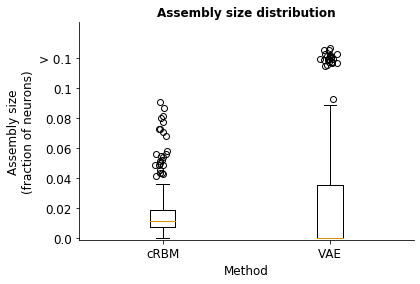

In [145]:
## Boxplots:

as_dict = {}
ylim = 0.1
y_newmax = 0.12

ax_boxplot = plt.subplot(111)
for dr in ['rbm', 'vae']:
    as_dict[dr] = get_assembly_sizes(weight_mat=weights[dr])
    as_dict[dr][as_dict[dr] > ylim] = y_newmax + np.random.randn(np.sum(as_dict[dr] > ylim)) / 250
tmp = ax_boxplot.boxplot([as_dict['rbm'], as_dict['vae']], showfliers=True)
for ii in range(len(as_dict)):
    n_outliers = len(tmp['fliers'][ii].get_xdata())
    tmp['fliers'][ii].set_xdata(np.random.randn(n_outliers) / 40 + 1 + ii)
# for ii in range(len(as_dict)):
#     outliers = tmp['fliers'][ii].get_ydata()
#     tmp['fliers'][ii].set_visible(False)
#     sns.swarmplot(x=np.ones(len(outliers)) + ii, y=outliers, ax=ax_boxplot)
# tmp['fliers'][1].set_clip_on(False)
# ax_boxplot.scatter(np.ones(23) + 1 + np.random.randn(23) / 15, 
#                    np.zeros(23) + 0.12 + np.random.randn(23) / 250, 
#                                       marker='o', edgecolors='k', facecolors='none', clip_on=False)
# sns.stripplot(np.zeros(23) + 0.12 + np.random.randn(23) / 250, 
#                    ax=ax_boxplot,
#                    marker='o', edgecolors='k', facecolors='none', clip_on=False)
ax_boxplot.set_xticklabels(['cRBM', 'VAE'])
ax_boxplot.set_ylim([-0.001, y_newmax * 1.2])
yres = 0.02
yticks = np.arange(0, y_newmax + yres, yres)
yticklabels = list(copy.deepcopy(yticks) )
yticklabels[-1] = f'> {ylim}'
ax_boxplot.set_yticks(yticks)
ax_boxplot.set_yticklabels(yticklabels)
ax_boxplot.set_xlabel('Method')
ax_boxplot.set_ylabel('Assembly size\n(fraction of neurons)')
ax_boxplot.set_title('Assembly size distribution', fontdict={'weight': 'bold'})
ax_boxplot.spines['top'].set_visible(False)
ax_boxplot.spines['right'].set_visible(False)

<BarContainer object of 2 artists>

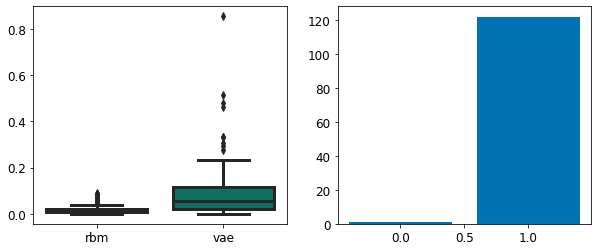

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


as_null_dict = {}
as_dict = {}
for dr in ['rbm', 'vae']:
    as_dict[dr] = get_assembly_sizes(weight_mat=weights[dr])
    as_null_dict[dr] = np.sum(as_dict[dr] == 0)
    # as_dict[dr] = as_dict[dr][as_dict[dr] > 0]
    # as_null_dict[dr] = np.zeros_like(as_dict[dr]) + np.nan
    # as_null_dict[dr][:np.sum(as_dict[dr] == 0)] = np.random.randn(np.sum(as_dict[dr] == 0)) / 90 - 0.05
    as_dict[dr][as_dict[dr] == 0] = np.nan
    # as_dict[dr][as_dict[dr] > 0.15] = 0.15 + np.random.randn(np.sum(as_dict[dr] > 0.15)) / 200
    
    
    as_df = pd.DataFrame(as_dict)

# sns.swarmplot(data=as_df, color='0.25', palette=[dr_colors['rbm'], dr_colors['vae']])
# sns.swarmplot(data=pd.DataFrame(as_null_dict), color='0.25', 
#             palette=[dr_colors['rbm'], dr_colors['vae']], 
#                 marker='X')

sns.boxplot(data=as_df,# showcaps=False,boxprops={'facecolor':'None', "zorder":10},
                 #showfliers=False,whiskerprops={'linewidth':0, "zorder":10},
                  palette=[dr_colors['rbm'], dr_colors['vae']], ax=ax[0])
# sns.catplot(data=pd.DataFrame(as_null_dict), color='0.25', palette=[dr_colors['rbm'], r_colors['vae']], marker='X', kind='swarm')
# plt.scatter(x=1, y=-0.25)
# plt.ylim([0, 0.1])
# plt.legend()

ax[1].bar(x=[0, 1], height=as_null_dict.values())

## Train test difference:

In [4]:
dict_path = '/home/thijs/repos/dnp-code/results_df_lookup/traintest_stats/20180912-Run01/'

all_dict_names = os.listdir(dict_path)
all_dict_tt_stats = {}
for dn in all_dict_names:
    raw_sign = dn.split('_')[-2]
    if len(raw_sign) == 7:  # test123, a 10-seg split
        sign = f'10seg_{raw_sign[4:]}'
    elif raw_sign[5:12] == 'nseg100':  # test-nseg100-it(x)x, 100-seg split
        sign = f'100seg_{raw_sign.split("-")[-1]}'
    elif raw_sign[4:10] == 'random':  # testrandom5050-x(x)
        sign = raw_sign[4:]
    elif raw_sign == 'test-time4000':
        sign = raw_sign[5:]
    all_dict_tt_stats[sign] = pickle.load(open(dict_path + dn, 'rb'))


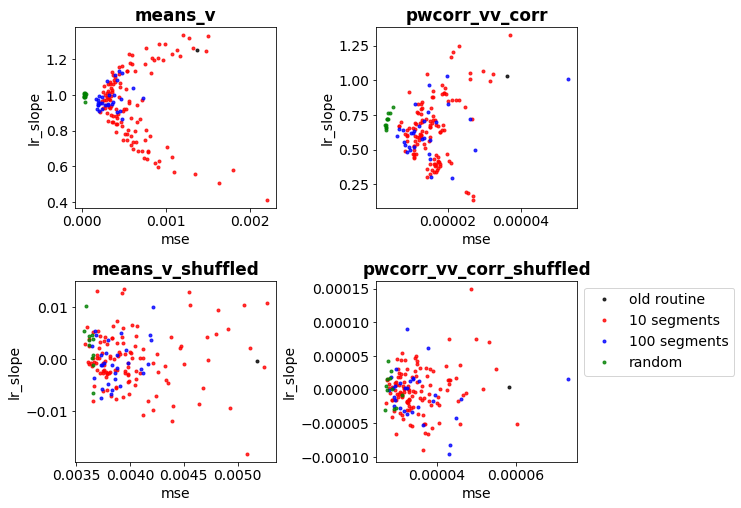

In [5]:
def extract_stat_array(dictionary, comp_moment='means_v', stat='sse'):
    arr = np.zeros(len(dictionary))
    sign_arr = np.zeros(len(dictionary), dtype='object')
    i_d = 0
    for sign, dd in dictionary.items():
        sign_arr[i_d] = sign
        if stat == 'mse':
            arr[i_d] = dd[comp_moment]['sse'].astype('float64') / dd[comp_moment]['n_elements']
        elif stat == 'rmse':
            arr[i_d] = np.sqrt(dd[comp_moment]['sse'].astype('float64') / dd[comp_moment]['n_elements'])
        else:
            arr[i_d] = dd[comp_moment][stat]    
        i_d += 1
    return arr, sign_arr

plt.rcParams['figure.figsize'] = (9, 8)
plt.rcParams['font.size'] = 14
plt.subplots_adjust(wspace=0.5, hspace=0.4)
xstat = 'mse'
ystat = 'lr_slope'
for i_cm, cm in enumerate(['means_v', 'pwcorr_vv_corr', 'means_v_shuffled', 'pwcorr_vv_corr_shuffled']):
    plt.subplot(2, 2, 1 + i_cm)
    xdata, xsign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment=cm, stat=xstat)
    ydata, ysign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment=cm, stat=ystat)

    inds_shift_10seg = [x for x, s in enumerate(xsign) if s[:5] == '10seg']
    inds_shift_100seg = [x for x, s in enumerate(xsign) if s[:6] == '100seg']
    inds_random_50 = [x for x, s in enumerate(xsign) if s[:10] == 'random5050']
    inds_random_70 = [x for x, s in enumerate(xsign) if s[:10] == 'random7030']
    inds_old = [x for x, s in enumerate(xsign) if s[:10] == 'time4000']
    plt.plot(xdata[inds_old], ydata[inds_old], '.', color='black', alpha=0.8, label='old routine')
    plt.plot(xdata[inds_shift_10seg], ydata[inds_shift_10seg], '.', color='red', alpha=0.8, label='10 segments')
    plt.plot(xdata[inds_shift_100seg], ydata[inds_shift_100seg], '.', color='blue', alpha=0.8, label='100 segments')
#     plt.plot(xdata[inds_random_50], ydata[inds_random_50], '.', color='orange', alpha=0.8)
    plt.plot(xdata[inds_random_70], ydata[inds_random_70], '.', color='green', alpha=0.8, label='random')
    plt.xlabel(xstat); plt.ylabel(ystat); plt.title(cm, weight='bold')

    if i_cm == 3:
        plt.legend(bbox_to_anchor=(1, 1))

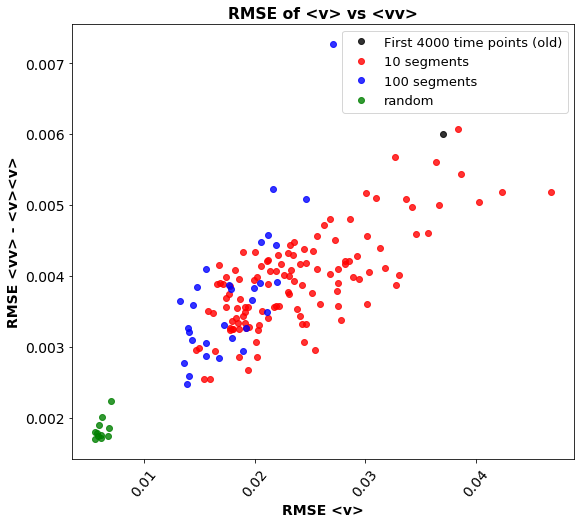

In [6]:

plt.subplots_adjust(wspace=0.5, hspace=0.4)
xstat = 'rmse'
plt.subplot(111)
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['lines.markersize'] = 12
plt.rcParams['font.size'] = 13
xdata, xsign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment='means_v', stat=xstat)
ydata, ysign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment='pwcorr_vv_corr', stat=xstat)

inds_shift_10seg = [x for x, s in enumerate(xsign) if s[:5] == '10seg']
inds_shift_100seg = [x for x, s in enumerate(xsign) if s[:6] == '100seg']
inds_random_50 = [x for x, s in enumerate(xsign) if s[:10] == 'random5050']
inds_random_70 = [x for x, s in enumerate(xsign) if s[:10] == 'random7030']
inds_old = [x for x, s in enumerate(xsign) if s[:10] == 'time4000']
plt.plot(xdata[inds_old], ydata[inds_old], '.', 
         color='black', alpha=0.8, label='First 4000 time points (old)')
plt.plot(xdata[inds_shift_10seg], ydata[inds_shift_10seg], '.', 
         color='red', alpha=0.8, label='10 segments')
plt.plot(xdata[inds_shift_100seg], ydata[inds_shift_100seg], '.', 
         color='blue', alpha=0.8, label='100 segments')
#     plt.plot(xdata[inds_random_50], ydata[inds_random_50], '.', 
# color='orange', alpha=0.8)
plt.plot(xdata[inds_random_70], ydata[inds_random_70], '.', 
         color='green', alpha=0.8, label='random')
plt.xlabel('RMSE <v>', weight='bold'); plt.ylabel('RMSE <vv> - <v><v>', weight='bold') 
plt.title('RMSE of <v> vs <vv>', weight='bold')
# plt.xlim([0, xdata.max()]); plt.ylim([0, ydata.max()])
plt.xticks(rotation=50)
plt.legend()

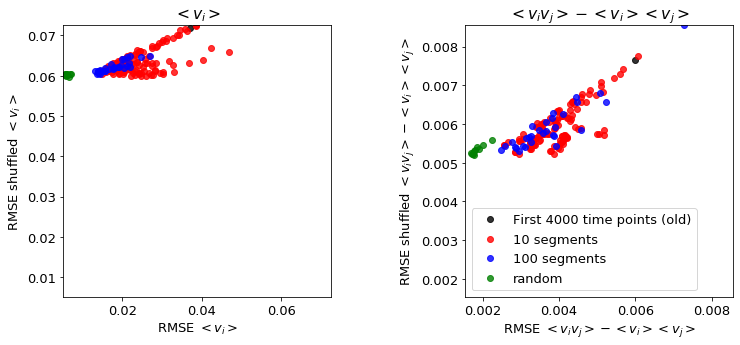

In [10]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplots_adjust(wspace=0.5, hspace=0.4)
xstat = 'rmse'
for i_cm, cm in enumerate(['means_v', 'pwcorr_vv_corr']):
    plt.subplot(1, 2, 1 + i_cm)
    xdata, xsign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment=cm, stat=xstat)
    if i_cm < 2:
        ydata, ysign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment=cm + '_shuffled', stat=xstat)
    else:
        ydata, ysign = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment='pwcorr_vv_corr', stat=xstat)
#     if cm == 'means_v':
#         print(xsign[np.argsort(xdata)])
    inds_shift_10seg = [x for x, s in enumerate(xsign) if s[:5] == '10seg']
    inds_shift_100seg = [x for x, s in enumerate(xsign) if s[:6] == '100seg']
    inds_random_50 = [x for x, s in enumerate(xsign) if s[:10] == 'random5050']
    inds_random_70 = [x for x, s in enumerate(xsign) if s[:10] == 'random7030']
    inds_old = [x for x, s in enumerate(xsign) if s[:10] == 'time4000']
    plt.plot(xdata[inds_old], ydata[inds_old], '.', 
         color='black', alpha=0.8, label='First 4000 time points (old)')
    plt.plot(xdata[inds_shift_10seg], ydata[inds_shift_10seg], '.', 
             color='red', alpha=0.8, label='10 segments')
    plt.plot(xdata[inds_shift_100seg], ydata[inds_shift_100seg], '.', 
             color='blue', alpha=0.8, label='100 segments')
#     plt.plot(xdata[inds_random_50], ydata[inds_random_50], '.', 
#              color='orange', alpha=0.8, label='random 50/50')
    plt.plot(xdata[inds_random_70], ydata[inds_random_70], '.', 
             color='green', alpha=0.8, label='random')
    plt.xlabel(f'RMSE {mom_names[cm]}'); 
    if i_cm < 2:
        plt.ylabel(f'RMSE shuffled {mom_names[cm]}'); plt.title(mom_names[cm], weight='bold')
        plt.xlim([np.minimum(xdata.min(), ydata.min()), np.maximum(xdata.max(), ydata.max())])
        plt.ylim([np.minimum(xdata.min(), ydata.min()), np.maximum(xdata.max(), ydata.max())])
    else:
        plt.ylabel('pwcorr_vv_corr'); plt.title('<v> vs <vv>', weight='bold')
    if i_cm == 1:
        plt.legend()

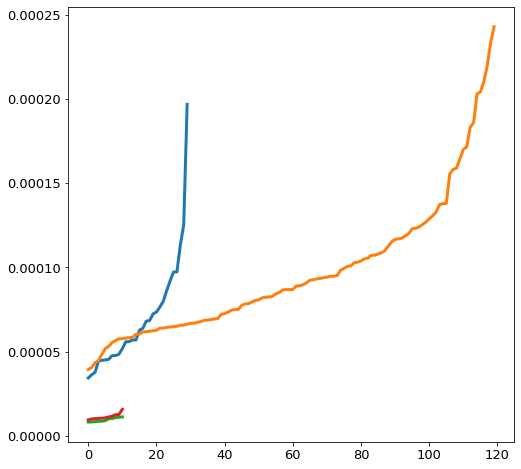

In [8]:
zdata1, zsign1 = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment='pwcorr_vv_corr', stat='rmse')
zdata2, zsign2 = extract_stat_array(dictionary=all_dict_tt_stats, comp_moment='means_v', stat='rmse')
assert (zsign1 == zsign2).all()
# zdata[np.where(zsign == '10seg_279')[0]]
zdata3 = zdata1 * zdata2
sorted_splits = zsign1[np.argsort(zdata3)]
# automate extraction
# sorted_splits
sorted_10seg_testsegs = [x[-3:] for x in sorted_splits if x[:5] == '10seg']
len(sorted_10seg_testsegs)
plt.plot(np.sort(zdata3[inds_shift_100seg]))
plt.plot(np.sort(zdata3[inds_shift_10seg]))
plt.plot(np.sort(zdata3[inds_random_50]))
plt.plot(np.sort(zdata3[inds_random_70]))

In [23]:
sorted_10seg_testsegs[11]

'267'

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


10seg_179 0.96591187
10seg_267 1.0609894
10seg_289 1.0734282
100seg_it26 0.9721336
random7030-6 0.99108607
time4000 1.2480865
10seg_179 0.6677959
10seg_267 0.5264142
10seg_289 0.9066028
100seg_it26 0.60152006
random7030-6 0.6420707
time4000 1.0335329


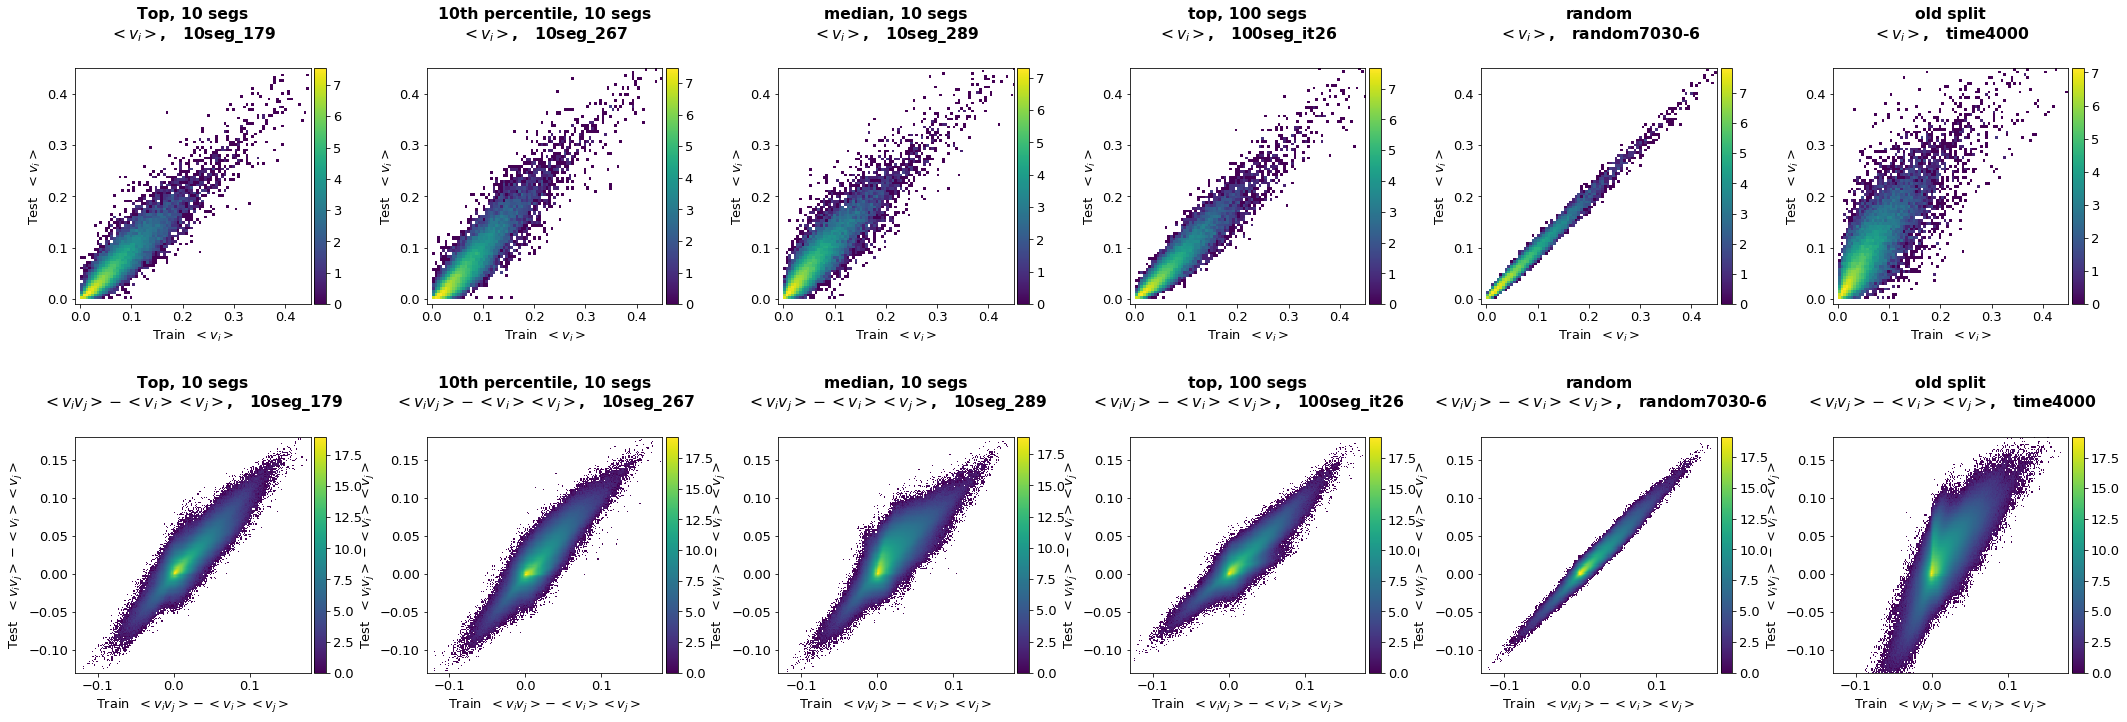

In [21]:
# plt.hist2d(tmp, tmp1, bins=50
list_splits = ['10seg_179', '10seg_267', '10seg_289', '100seg_it26', 'random7030-6', 'time4000']
custom_title = ['Top, 10 segs', '10th percentile, 10 segs', 'median, 10 segs', 'top, 100 segs', 'random', 'old split']
plt.rcParams['figure.figsize'] = (6 * len(list_splits), 12)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
ax_dict = {}
im = {}
for i_name, name_mom in enumerate(['means_v', 'pwcorr_vv_corr']):
    for i_split, name_split in enumerate(list_splits):  # (['10seg_135', '100seg_it6' 'random5050-3', 'random7030-4'
        ind_plot = 1 + (len(list_splits) * i_name) + i_split
        ax_dict[ind_plot] = plt.subplot(2, len(list_splits), ind_plot)
        xbins = all_dict_tt_stats[name_split][name_mom]['histogram2d'][1]
        ybins = all_dict_tt_stats[name_split][name_mom]['histogram2d'][2]
        im[ind_plot] = ax_dict[ind_plot].imshow(np.log(all_dict_tt_stats[name_split][name_mom]['histogram2d'][0]), 
                                 interpolation='nearest', origin='low',
                   extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
        
        divider = make_axes_locatable(ax_dict[ind_plot])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im[ind_plot], cax=cax)
        if 'means_v' in name_mom:
            ax_dict[ind_plot].set_xlim([-0.01, 0.45]); ax_dict[ind_plot].set_ylim([-0.01, 0.45])
        else:
            ax_dict[ind_plot].set_xlim([-0.13, 0.18]); ax_dict[ind_plot].set_ylim([-0.13, 0.18])
        ax_dict[ind_plot].set_title(f'{custom_title[(ind_plot-1) % 6]}\n{mom_names[name_mom]},   {name_split}', weight='bold', y=1.1)
        ax_dict[ind_plot].set_xlabel(f'Train  {mom_names[name_mom]}'); 
        ax_dict[ind_plot].set_ylabel(f'Test  {mom_names[name_mom]}')
        print(name_split, all_dict_tt_stats[name_split][name_mom]['lr_slope'])

KeyError: 'pwcorr_vv'

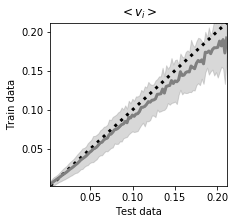

In [5]:
plt.rcParams['figure.figsize'] = (12, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ff = {}
for i_loop, comp_moment in enumerate(['means_v', 'pwcorr_vv', 'pwcorr_vv_corr']):
    dd = dict_tt_stats[comp_moment]
    ff[i_loop] = plt.subplot(1, 3, i_loop + 1)
    pf.plot_binned_stats(ff[i_loop], dd['plot_bins'], dd['means_bins'], dd['std_bins'])
    ff[i_loop].set_title(r'{}'.format(mom_names[comp_moment]))
    ff[i_loop].set_xlabel('Test data'); ff[i_loop].set_ylabel('Train data')
    
sns.despine()

segment 0, size 600
segment 1, size 600
segment 2, size 600
segment 3, size 600
segment 4, size 600
segment 5, size 600
segment 6, size 600
segment 7, size 600
segment 8, size 600
segment 9, size 600


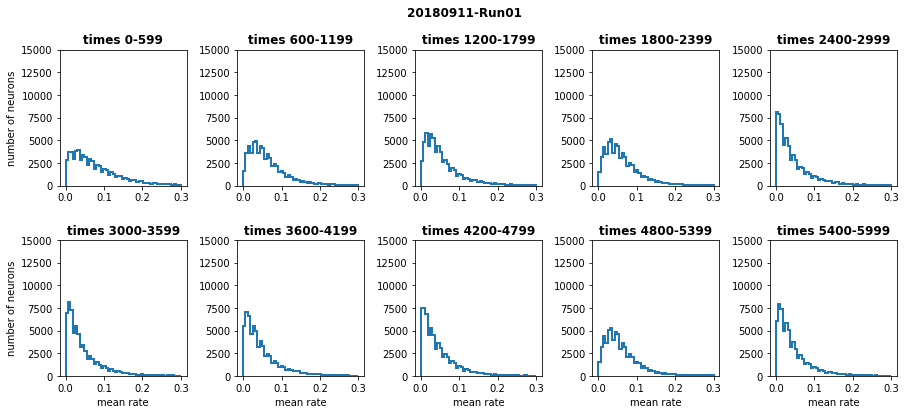

In [4]:
# all_shuffled_time_inds = np.random.permutation(full_data['wb'].shape[1])
all_time_inds = np.arange(full_data['wb'].shape[1])
n_seg = 10
plot_mean_distr = True
n_perseg = int(np.floor(full_data['wb'].shape[1] / n_seg))
inds_seg = {}
for seg in range(n_seg):
    if seg < (n_seg - 1):
        inds_seg[seg] = all_time_inds[(n_perseg * seg):(n_perseg * (seg + 1))]
    else:  # final one

        inds_seg[seg] = all_time_inds[(n_perseg * seg):]  # take last few
    print(f'segment {seg}, size {len(inds_seg[seg])}')

plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ff = {}

if plot_mean_distr:
    for seg in range(n_seg):
        means_train = np.mean(full_data['wb'][:, inds_seg[seg]], 1)
    #     means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    #     ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)
    #     print(ro[0])
        ff[seg] = plt.subplot(2, 5, seg + 1)
    #     plot_binned_stats(ff[seg], plot_bins, means_bins, std_bins)
        ff[seg].hist(means_train, bins=np.linspace(0, 0.3, 50), histtype='step', linewidth=2)
        ff[seg].set_title(f'times {inds_seg[seg][0]}-{inds_seg[seg][-1]}', weight='bold')
        ff[seg].set_ylim([0, 15000])
    for seg in [0, 5]:
        ff[seg].set_ylabel('number of neurons')
    for seg in np.arange(5, 10):
        ff[seg].set_xlabel('mean rate');
    plt.suptitle(data_set, weight='bold')
#     plt.savefig(f'pdfs/data_sets/mean_10segs_{data_set}.pdf', bbox_inches='tight')

In [5]:
def export_inds(test_segs=[0], save_file=True, file_name=None, save_folder=str()):
    """Function to export time indices corresponding to test_segs"""

    if file_name is None:
        test_str = ''.join([str(x) for x in test_segs])
        file_name = f'train_test_inds__test_segs_{test_str}_nseg{n_seg}.pkl'
    else:
        test_str = file_name
        file_name = f'train_test_inds__test_segs_{test_str}_nseg{n_seg}.pkl'
    train_segs = np.array(list(set(np.arange(n_seg)).difference(set(test_segs)))) # train is difference of test set
#     print(train_segs, test_segs)
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
    dd = {'train_segs': train_segs, 'test_segs': test_segs,
          'train_inds': new_train_inds, 'test_inds': new_test_inds}
    
    if save_file:
        ff = open(save_folder + file_name, 'wb')
        pickle.dump(dd, ff)
    return dd

# export_inds(test_segs=[1, 5, 9], save_file=True, save_folder='/home/thijs/repos/dnp-code/train_test_inds/')

In [6]:
## Create indices for 10 segments (for all 10 choose 3 combinations)

n_combs = 0
for comb, test_segs in enumerate(itertools.combinations(np.arange(n_seg), 3)):
    n_combs += 1
print(f'Number of combinations is {n_combs}')

df_combs_mean_stats = pd.DataFrame({x: np.zeros(n_combs) for x in ['test_segs', 
                                    'train_segs' ,'pearson', 'lr_slope', 'lr_intercept',
                                      'sse_traintest', 'lr_slope_bins', 'lr_intercept_bins']})
df_combs_mean_stats = df_combs_mean_stats.astype('object')


# ff = {}
for comb, test_segs in tqdm(enumerate(itertools.combinations(np.arange(n_seg), 3))):  # iterate through unique combinations

    ## Create indices
    #     test_segs = np.random.choice(a=n_seg, size=3, replace=False)
    test_segs = np.array(list(test_segs))
    train_segs = np.array(list(set(np.arange(n_seg)).difference(set(test_segs)))) # train is difference of test set
#     print(train_segs, test_segs)
    df_combs_mean_stats['train_segs'].iat[comb] = train_segs
    df_combs_mean_stats['test_segs'].iat[comb] = test_segs
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
        
    ## Save indices
    _ = export_inds(test_segs=list(test_segs), save_file=True, 
                save_folder='/home/thijs/repos/dnp-code/train_test_inds/20180911-Run01/')
        
#     ## Compute means
#     means_train = np.mean(full_data['wb'][:, new_train_inds], 1)  # compute means
#     means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    
#     ## Compute metrics
#     ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)  # compute corr
# #     print(ro[0])
#     df_combs_mean_stats['pearson'].iat[comb] = ro[0]
#     inds_nn = ~np.isnan(means_bins)
#     assert len(inds_nn) == len(means_bins)  # no nans here right?
#     plot_bins, means_bins, std_bins = plot_bins[inds_nn], means_bins[inds_nn], std_bins[inds_nn]
#     lr = sklearn.linear_model.LinearRegression().fit(plot_bins[:, np.newaxis], means_bins)  # find lin reg to find slope and intercept
#     df_combs_mean_stats['lr_slope_bins'].iat[comb] = lr.coef_[0]
#     df_combs_mean_stats['lr_intercept_bins'].iat[comb] = lr.intercept_
    
#     lr = sklearn.linear_model.LinearRegression().fit(means_train[:, np.newaxis], means_test)  # find lin reg to find slope and intercept
#     df_combs_mean_stats['lr_slope'].iat[comb] = lr.coef_[0]
#     df_combs_mean_stats['lr_intercept'].iat[comb] = lr.intercept_
    
#     df_combs_mean_stats['sse_traintest'].iat[comb] = np.mean(np.power(means_train - means_test, 2))
    

120it [00:00, 1558.88it/s]

Number of combinations is 120


In [7]:
## 100 segments (make random set of test segs, because 100 choose 30 is impossible)

assert n_seg == 100
n_combs = 30
test_size = 30


for comb in range(n_combs):
    test_segs = np.random.choice(a=n_seg, size=test_size, replace=False)


    ## Create indices
#     test_segs = np.random.choice(a=n_seg, size=3, replace=False)
    test_segs = np.array(list(test_segs))
    train_segs = np.array(list(set(np.arange(n_seg)).difference(set(test_segs)))) # train is difference of test set
#     print(train_segs, test_segs)
#     df_combs_mean_stats['train_segs'].iat[comb] = train_segs
#     df_combs_mean_stats['test_segs'].iat[comb] = test_segs
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
        
    # Save indices
    _ = export_inds(test_segs=list(test_segs), save_file=True, file_name=f'it{comb}',
                save_folder='/home/thijs/repos/dnp-code/train_test_inds/')
        
#     ## Compute means
#     means_train = np.mean(full_data['wb'][:, new_train_inds], 1)  # compute means
#     means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    
#     ## Compute metrics
#     ro, (plot_bins, means_bins, std_bins) = bin_stats(means_test, means_train)  # compute corr
# #     print(ro[0])
#     df_combs_mean_stats['pearson'].iat[comb] = ro[0]
#     inds_nn = ~np.isnan(means_bins)
#     assert len(inds_nn) == len(means_bins)  # no nans here right?
#     plot_bins, means_bins, std_bins = plot_bins[inds_nn], means_bins[inds_nn], std_bins[inds_nn]
#     lr = sklearn.linear_model.LinearRegression().fit(plot_bins[:, np.newaxis], means_bins)  # find lin reg to find slope and intercept
#     df_combs_mean_stats['lr_slope_bins'].iat[comb] = lr.coef_[0]
#     df_combs_mean_stats['lr_intercept_bins'].iat[comb] = lr.intercept_
    
#     lr = sklearn.linear_model.LinearRegression().fit(means_train[:, np.newaxis], means_test)  # find lin reg to find slope and intercept
#     df_combs_mean_stats['lr_slope'].iat[comb] = lr.coef_[0]
#     df_combs_mean_stats['lr_intercept'].iat[comb] = lr.intercept_
    
#     df_combs_mean_stats['sse_traintest'].iat[comb] = np.mean(np.power(means_train - means_test, 2))
    

In [17]:
for comb, test_segs in tqdm(enumerate(itertools.combinations(np.arange(n_seg), 3))):  # iterate through unique combinations
    print(comb, test_segs)

120.0

(0.95, 1.05)

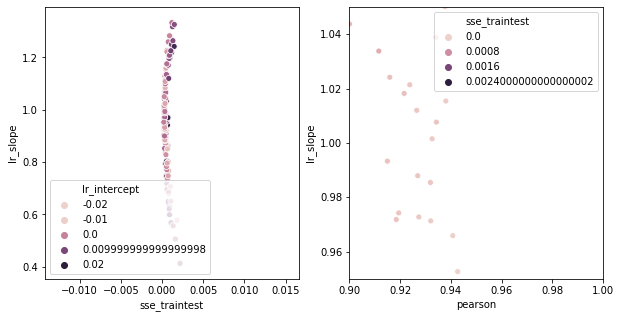

In [10]:
plt.rcParams['figure.figsize'] = (10, 5)

plt.subplot(121)
sns.scatterplot(data=df_combs_mean_stats, x='sse_traintest', y='lr_slope', hue='lr_intercept')


plt.subplot(122)
sns.scatterplot(data=df_combs_mean_stats, x='pearson', y='lr_slope', hue='sse_traintest')

plt.xlim([0.9, 1])
plt.ylim([0.95, 1.05])

In [11]:
comb_list = np.where(np.logical_and(np.abs(df_combs_mean_stats['lr_slope'] - 1) < 0.05,
               df_combs_mean_stats['pearson'] > 0.9))[0]

In [13]:
test_segs

array([7, 8, 9])

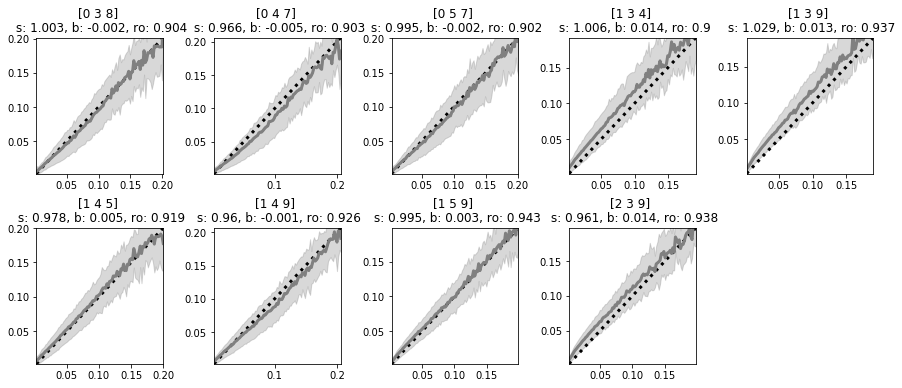

In [227]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i_loop, comb in enumerate(comb_list):
    train_segs = df_combs_mean_stats['train_segs'].iat[comb]
    test_segs = df_combs_mean_stats['test_segs'].iat[comb]
#     print(train_segs, test_segs)
 
    new_test_inds = np.array([])
    new_train_inds = np.array([])
    for ts in test_segs:  # concat indices belonging to test segments
        new_test_inds = np.concatenate((new_test_inds, inds_seg[ts])).astype('int')
    for ts in train_segs:
        new_train_inds = np.concatenate((new_train_inds, inds_seg[ts])).astype('int')
        
    means_train = np.mean(full_data['wb'][:, new_train_inds], 1)  # compute means
    means_test = np.mean(full_data['wb'][:, new_test_inds], 1)
    ro, (plot_bins, means_bins, std_bins) = af.bin_stats(means_test, means_train)  # compute corr
#     print(ro[0])
    df_combs_mean_stats['pearson'].iat[comb] = ro[0]
    inds_nn = ~np.isnan(means_bins)
    assert len(inds_nn) == len(means_bins)  # no nans here right?
    plot_bins, means_bins, std_bins = plot_bins[inds_nn], means_bins[inds_nn], std_bins[inds_nn]
#     print(df_combs_mean_stats['lr_slope'].iat[comb], 
#           df_combs_mean_stats['lr_intercept'].iat[comb], 
#           df_combs_mean_stats['pearson'].iat[comb])
    
    ff[comb] = plt.subplot(2, 5, i_loop + 1)
    pf.plot_binned_stats(ff[comb], plot_bins, means_bins, std_bins)
    ff[comb].set_title(f'{test_segs} \n s: {np.round(df_combs_mean_stats["lr_slope"].iat[comb], 3)}, b: {np.round(df_combs_mean_stats["lr_intercept"].iat[comb], 3)}, ro: {np.round(df_combs_mean_stats["pearson"].iat[comb], 3)}')

In [95]:
nn = int(1e6)
print(nn)
tmp = np.abs(np.random.randn(nn).astype('float32')) + np.linspace(0, 10, nn)
tmp1 = np.abs(np.random.randn(nn).astype('float32')) + np.linspace(0, 5, nn)

tmp_m = sklearn.linear_model.LinearRegression().fit(tmp[:, np.newaxis], tmp1)
print(tmp_m.coef_, tmp_m.intercept_)

plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(tmp, tmp1, '.')
plt.plot([0, 14], [0, 14], '--')
arr = np.arange(0, 14)
plt.plot(arr, tmp_m.coef_[0] * arr + tmp_m.intercept_)

hist, xbins, ybins = np.histogram2d(tmp, tmp1, bins=100)
hist = hist.T

1000000
